In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import pandas as pd

In [2]:
import matplotlib.dates as mdates

In [3]:
import math
import plotly.express as px

In [4]:
from torch.utils.data import Dataset, DataLoader

In [5]:
import yfinance as yf #importing yahoo finance
from datetime import date, timedelta, datetime

In [6]:
euronext = pd.read_csv('/teamspace/studios/this_studio/stockpred/eurotickers.csv', sep=';')

In [7]:
euronext_f = euronext[['Name', 'Symbol']]

In [8]:
# fetching S&P 500 stocks 
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500_stocks = table[0]

# extracting tickers and company names
tickers = sp500_stocks['Symbol'].tolist()
companies = sp500_stocks['Security'].tolist()

# creating a dataframe
dictionary = pd.DataFrame({
    'Name': companies,
    'Symbol': tickers,
})

# saving to CSV
tickerlist = dictionary.to_dict(orient='records')

In [9]:
combined_data= pd.concat([dictionary, euronext_f], ignore_index=True)
print(combined_data)

                     Name Symbol
0                      3M    MMM
1             A. O. Smith    AOS
2     Abbott Laboratories    ABT
3                  AbbVie   ABBV
4               Accenture    ACN
...                   ...    ...
3972   ZOOM COMMUNICATION    1ZM
3973   ZOOM COMMUNICATION    2ZM
3974               ZUCCHI    ZUC
3975                ZWIPE  ZWIPE
3976             ZWIPE TR  ZWIPJ

[3977 rows x 2 columns]


In [10]:
company = input("Enter the company's name")
df = None

In [11]:
if company:  # checking if the user has entered a ticker
    try:
        matching_tickers = combined_data[combined_data['Name'].str.contains(company, case=False)]
        if not matching_tickers.empty:
            tickers = matching_tickers['Symbol'].tolist()
            
            if len(tickers) > 1:
                ticker = tickers[0]
            # Downloading historical stock data for the entered ticker
            df = yf.download(ticker, period = '10y')

        
    except Exception as e:
            print(f"An error occurred: {e}")
else:
    print("Please enter a valid company.")


[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True


In [12]:
if df.empty : 
    print("dataset is empty")

In [13]:
# Train Test Split
training_data_len = math.ceil(len(df)*.8)
training_data_len

train_data = df[:training_data_len][[('Open', ticker)]]
test_data = df[training_data_len:][[('Open', ticker)]]

print(train_data.shape, test_data.shape)

(2013, 1) (503, 1)


In [14]:
test_data.columns

MultiIndex([('Open', 'NVDA')],
           names=['Price', 'Ticker'])

In [15]:
# open price values
try :
  dataset_test = test_data.Open.values
except :
  dataset_test = test_data[('Open', ticker)].values
#1D to 2D
dataset_test = np.reshape(dataset_test, (-1,1))
dataset_test.shape

(503, 1)

In [16]:
dataset_train = train_data.Open.values
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(2013, 1)

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

# scaling dataset
scaled_train= scaler.fit_transform(dataset_train)

print(scaled_train[:5])
# normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)
print(*scaled_test[:5])

[[0.00230841]
 [0.00195786]
 [0.00216235]
 [0.00220616]
 [0.00208201]]
[0.] [0.0004818] [0.00812727] [0.00676875] [0.00921721]


In [18]:
#creating sequences and labels for training data
sequence_length = 30 # nb of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i+sequence_length])
    y_train.append(scaled_train[i+1:i+sequence_length+1])
X_train, y_train = np.array(X_train), np.array(y_train)

#converting data to Pytorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_train.shape, y_train.shape

(torch.Size([1983, 30, 1]), torch.Size([1983, 30, 1]))

In [19]:
#creating sequences and labels for testing data
sequence_length = 30 #nb of time steps to look back
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i+sequence_length])
    y_test.append(scaled_test[i+1:i+sequence_length+1])
X_test, y_test = np.array(X_test), np.array(y_test)

#converting data to Pytorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test.shape, y_test.shape

(torch.Size([473, 30, 1]), torch.Size([473, 30, 1]))

In [20]:
class LSTMModel(nn.Module):
      #input_size : number of features in input at each time step
      #hidden_size : number of LSTM units
      #num_layers : number of LSTM layers
    def __init__(self, input_size, hidden_size, num_layers):
      super(LSTMModel,self).__init__() #initializes the parent class nn.Module
      self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
      self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x): #defines forward pass of the neural network
      out, _ =self.lstm(x)
      out = self.linear(out)
      return out

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [22]:
input_size = 1
num_layers = 2
hidden_size = 64
output_size = 1

# defining  the model + loss function + optimizer
model = LSTMModel(input_size, hidden_size, num_layers).to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [24]:
batch_size = 32
# creating DataLoader for batch training
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#creating Dataloader for batch testing
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [25]:
num_epochs = 100
train_hist =[]
test_hist =[]
#training loop
for epoch in range(num_epochs):
    total_loss = 0.0

    #training
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss=loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

     # calculating average training loss and accuracy
    average_loss = total_loss /len(train_loader)
    train_hist.append(average_loss)

    # validation on test data
    model.eval()
    with torch.no_grad():
       total_test_loss = 0.0

       for batch_X_test, batch_y_test in test_loader:
           batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
           predictions_test = model(batch_X_test)
           test_loss = loss_fn(predictions_test, batch_y_test)

           total_test_loss += test_loss.item()
       #calculating average test loss and accuracy
       average_test_loss = total_test_loss / len(test_loader)
       test_hist.append(average_test_loss)
    if (epoch+1)%10==0:
      print(f'epoch[{epoch+1}/{num_epochs}] - Training Loss : {average_loss:.4f}, Test Loss : {average_test_loss:.4f}')

epoch[10/100] - Training Loss : 0.0005, Test Loss : 0.0012
epoch[20/100] - Training Loss : 0.0002, Test Loss : 0.0007
epoch[30/100] - Training Loss : 0.0002, Test Loss : 0.0007
epoch[40/100] - Training Loss : 0.0002, Test Loss : 0.0007
epoch[50/100] - Training Loss : 0.0002, Test Loss : 0.0007
epoch[60/100] - Training Loss : 0.0002, Test Loss : 0.0007
epoch[70/100] - Training Loss : 0.0002, Test Loss : 0.0007
epoch[80/100] - Training Loss : 0.0002, Test Loss : 0.0007
epoch[90/100] - Training Loss : 0.0002, Test Loss : 0.0007
epoch[100/100] - Training Loss : 0.0002, Test Loss : 0.0008


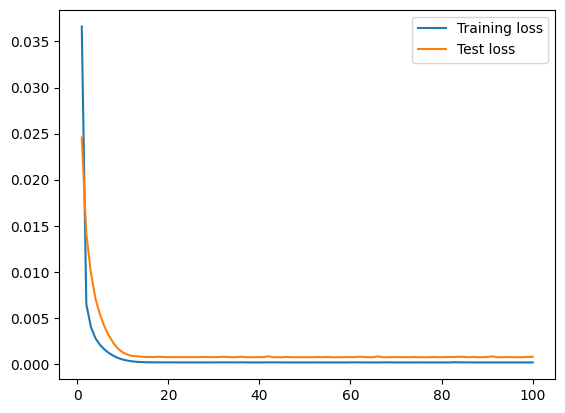

In [26]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex= True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

In [ ]:
# defining the number of future time steps to forecast
num_forecast_steps = 30

# converting to NumPy and remove singleton dimensions
sequence_to_plot = X_test.squeeze().cpu().numpy()

# use the last 30 data points as the starting point
historical_data = sequence_to_plot[-1]
print(historical_data.shape)

# initializing a list to store the forecasted value
forecasted_values = []

# using the trained model to forecast the future values
with torch.no_grad():
    for _ in range(num_forecast_steps*2):
        # converting the historical data to a tensor and add an extra dimension
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)

        # prediction for the next time step
        predicted_value = model(historical_data_tensor).cpu().numpy()[0,0]
        forecasted_values.append(predicted_value)

        # updating the historical data with the predicted value
        historical_data = np.roll(historical_data, -1)
        historical_data[-1] = predicted_value

# Generating future dates
last_date = test_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)
combined_index = test_data.index.append(future_dates)

(30,)


/tmp/ipykernel_22723/3363734754.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


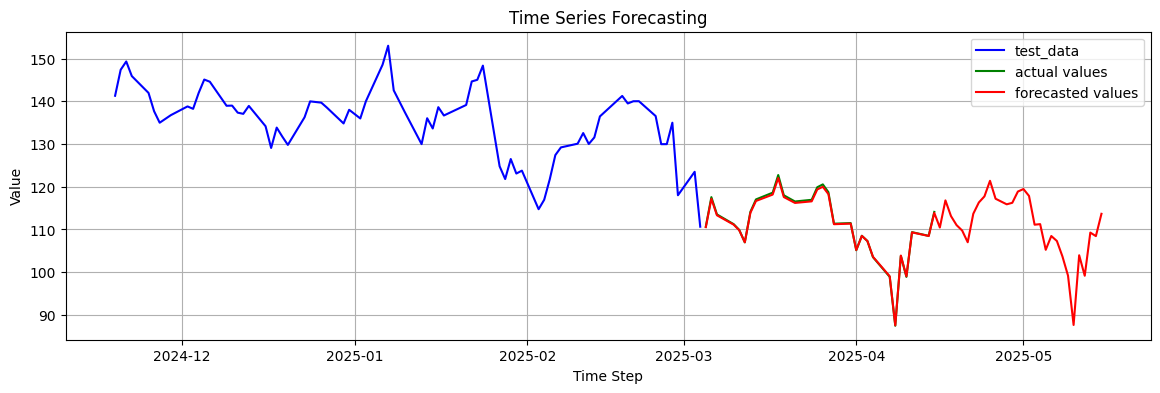

In [ ]:
#setting the size of the plot
plt.rcParams['figure.figsize']=[14, 4]


#Test Data
plt.plot(test_data.index[-100: -30], test_data.Open[-100:-30], label= "test_data", color = "b")
#reversing the scaling transformation
original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten()

#the historical data used as input for forecasting
plt.plot(test_data.index[-30:], original_cases, label='actual values', color='green')

#Forecasted Values
#reversing the scaling transformation
forecasted_cases = scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()
# plotting the forecasted values
plt.plot(combined_index[-60:], forecasted_cases, label='forecasted values', color='red')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)